# Using an LLM to generate a Travelling Salesman Problem

### WIP 


This notebook is my work-in-progress notebook (expect errors). 
Currently, this notebook uses a weighted sum of normalised price, time, and distance to define the weights of the edges of the graph. The user can input the scale factors (p) which will determine how much each factor contributes. 

Currently, the prices are not correct and are implemented using placeholders (for the most part). The price of transit is taken from GoogleMaps, and for the LLM method, the price is generated by the LLM. For walking and cycling, the price is assumed to be 0. For cars, ideally, I would use the LLM or an API to get an estimate for fuel price (per litre) in the local currency of the origin node. 

In [46]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence

import re 
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem
from dotenv import load_dotenv

import googlemaps
import os
from geopy.geocoders import Nominatim
import time

from plotting import plot_graph_and_path, plot_route_folium

load_dotenv("hidden.env")

True

In [47]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
maps_API_KEY = os.getenv('maps_API_KEY')
gmaps = googlemaps.Client(key=maps_API_KEY) 
geolocator = Nominatim(user_agent="tsp")

def seconds_to_hours(seconds): 
    if type(seconds) == str:
        s = int(seconds.split())
    else: 
        s = seconds
    return s/3600

In [48]:
def get_location(location, number, node_type): 

    if not isinstance(location, str): 
        raise ValueError("Location must be a string")
    if not isinstance(number, int) or number < 1 or number > 10: 
        raise ValueError("Number must be a positive integer <= 10.")
    if not isinstance(node_type, str):
        raise ValueError("Node type must be a string, e.g. landmarks, towns, cities.")

    prompt = PromptTemplate(
        input_variables=["number", "location", "node_type"],
        template="List {number} {node_type} to visit in {location}. One per line, itemized."
    )

    chat = ChatOpenAI(model="gpt-4", temperature=1.0)
    chain = prompt | chat
    response = chain.invoke({"number": number,"location": location, "node_type": node_type})
    original_nodes = re.findall(r"\d+\.\s*(.+)", response.content)
    nodes = [node + ", " + location for node in original_nodes]
    
    return original_nodes, nodes


In [49]:
def fuel_price(location): 
    """ A function I intend to implement with an API or scraping to get the fuel price (in order to estimate cost). 
        For now, I will just use the LLM (which is very naive).
    """

    gbp = 1.03
    prompt = PromptTemplate(
        input_variables=["location"],
        template="Return 1.03 GBP in the local currency of {location}. Only the number."
    )
    chain = prompt | ChatOpenAI(model="gpt-4", temperature=0.0)
    response = chain.invoke({"location": location})
    try:
        price = float(response.content)
    except:
        price = gbp # in the event of failure just use gbp as a default 
    return price

In [50]:
def estimate_driving_cost(distance, fuel_price, fuel_efficiency = 6.5): 

    """ A function to estimate the cost of driving a given distance. The fuel efficiency is in litres per 100 km. 
        distance is in km. fuel_price is in local currency per litre. 
    """

    litres = distance * fuel_efficiency / 100 
    cost = litres * fuel_price
    return cost

In [51]:
def get_distances(nodes): 
    
    number = len(nodes)
    positions = {}
    backup_prompt = PromptTemplate(
        input_variables=["place"],
        template = "Return the longitude and latitude of {place}. "
                "In the format (latitude, longitude). No other text.")
    
    ## Now add in the LLM option (this is especially necessary for cases where the gmaps API fails)
    transport_prompt = PromptTemplate(
        input_variables=["place1", "place2"],
        template= "Return the time (in hours), the method of transport (e.g. plane, ferry, etc), "
        "the distance for that method (km), and the price (in the local currency) of using that method. "
        "This should be the best (combination of time, distance, and cost) way of travelling from {place1} to {place2}. "
        "Return it in this format: (method, time, distance, price). No other text.")

    mode_prompt = PromptTemplate(
        input_variables=["mode", "place1", "place2"],
        template= "Return the time (in hours), the distance (km), and the price (in the local currency) of travelling "
        "from {place1} to {place2} by {mode}. Return it in this format: (time, distance, price). No other text.")
    
    for i in range(number): 
        for _ in range(3): 
            # give three attempts to get the location, if not then use the LLM to get the location
            node = geolocator.geocode(nodes[i])
            if node: 
                break 
        if not node: 
            chat = ChatOpenAI(model="gpt-4", temperature=0.0)
            chain = backup_prompt | chat
            response = chain.invoke({"place": nodes[i]}).content
            match = re.search(r"\(?\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)\s*\)?", response)
            if match:
                lat = float(match.group(1))
                lon = float(match.group(2))
            positions[i] = (lat, lon)
        else:
            positions[i] = (node.latitude, node.longitude)
            time.sleep(1) # to prevent overloading the geolocator API

    coords = list(positions.values())

    ## Get the distance matrices 
    walking_distances = gmaps.distance_matrix(coords, coords, mode = 'walking')
    driving_distances = gmaps.distance_matrix(coords, coords, mode = 'driving')
    bicycling_distances = gmaps.distance_matrix(coords, coords, mode = 'bicycling')
    transit_distances = gmaps.distance_matrix(coords, coords, mode = 'transit')

    superlatives = ["fastest", "shortest (distance)", "cheapest"]
    
    # At this point, we have the distance, time, but not cost for each pair of nodes 
    # I think we go off of the assumption that walking and cycling are free, and driving and transit have a cost 
    d = {} # d[i][j][mode] = [time, distance, cost]
    chat = ChatOpenAI(model="gpt-4", temperature=0.0)
    lists = [walking_distances, driving_distances, bicycling_distances, transit_distances]
        
    mode_names = ["foot", "car", "bike", "transit", "llm"]
    for origin in range(number): 

        d[origin] = {}
        
        for dest in range(number): 

            valid = False

            d[origin][dest] = {}

            if dest < origin: 
                d[origin][dest] = d[dest][origin]
                continue
            if dest == origin: 
                continue

            for i in range(4): 
                
                # Use the LLM if the API fails
                if lists[i]['rows'][origin]['elements'][dest]['status'] != 'OK':
                    chain = mode_prompt | chat
                    response = chain.invoke({"mode": mode_names[i], "place1": nodes[origin], "place2": nodes[dest]}).content
                    match = re.search(r"\(\s*([\d.]+\s*(?:h(?:ours?)?|hrs?))\s*,\s*([\d.]+\s*(?:km|kilometers?))\s*,\s*([^\)]+)\s*\)", response)
                    if match:
                        try: 
                            t = float(match.group(1).split()[0])
                            distance = float(match.group(2).split()[0])
                            cost = float(match.group(3))

                        except: 
                            t, distance, cost = np.inf, np.inf, np.inf
                
                    # otherwise discount this method of transport 
                    else:
                        t, distance, cost = np.inf, np.inf, np.inf
                    
                    d[origin][dest][mode_names[i]] = [t, distance, cost]

                else:
                    
                    valid = True
                    element = lists[i]['rows'][origin]['elements'][dest]
                    dist = element['distance']['value']/1000
                    t = seconds_to_hours(element['duration']['value'])
                    if i in [0, 2]:
                        cost = 0
                    elif i == 1: 
                        cost = estimate_driving_cost(dist, fuel_price(nodes[origin]))
                    else: 
                        fare = element.get('fare', None)
                        if fare: 
                            cost = fare['value']
                        else:
                            cost = dist * 0.5 # just a placeholder for now 
                    
                    d[origin][dest][mode_names[i]] = [t, dist, cost]
            
            if not valid: 
                chain = transport_prompt | chat
                response = chain.invoke({"priority_superlative": superlatives[-1], "place1": nodes[origin], "place2": nodes[dest]}).content
                match = re.search(
                    r"\(\s*(.+?)\s*,"             # Method
                    r"\s*([\d.]+)\s*\w*\s*,"      # Time (float + optional 'hours' or 'h')
                    r"\s*([\d.]+)\s*\w*\s*,"      # Distance (float + optional 'km' etc.)
                    r"\s*(?:[\$£€]|)?([\d.]+)(?:\s*\w+)?\s*\)",  # Price: optional symbol or currency word
                    response)

                if match:
                    method = match.group(1)
                    t = float(match.group(2))
                    distance = float(match.group(3))
                    cost = float(match.group(4))
                    d[origin][dest]['llm'] = [t, distance, cost, method]
                
                else: 
                    d[origin][dest]['llm'] = [np.inf, np.inf, np.inf, '']
            else: 
                d[origin][dest]['llm'] = [np.inf, np.inf, np.inf, '']
            
            

    return d, positions

In [63]:
def get_best_method(d, priority, number):

    mode_names = ["foot", "car", "bike", "transit", "llm"]
    for origin in range(number): 
        for dest in range(origin + 1, number): 
            times, dists, costs = [], [], []
            for i in range(5): 
                times.append(d[origin][dest][mode_names[i]][0])
                dists.append(d[origin][dest][mode_names[i]][1])
                costs.append(d[origin][dest][mode_names[i]][2])

            times = np.array(times)
            dists = np.array(dists)
            costs = np.array(costs)

            max_t = np.max([j for j in times if j < np.inf])
            max_d = np.max([j for j in dists if j < np.inf])
            max_c = np.max([j for j in costs if j < np.inf])

            eps = 1e-8

            weighted_costs = (priority[0] + eps) * times / max_t
            weighted_costs += (priority[1] + eps) * dists / max_d
            weighted_costs += (priority[2] + eps) * costs / max_c 
            best = mode_names[np.argmin(weighted_costs)]
            d[origin][dest]['best'] = best 
            d[origin][dest]['best_cost'] = np.min(weighted_costs)
    
    return 

In [75]:
def build_graph(d, number, nodes): 

    G = nx.complete_graph(number)
    labels = {i: nodes[i] for i in range(number)}

    for i in range(number): 
        for j in range(i + 1, number): 
            G[i][j]["weight"] = d[i][j]['best_cost']
    
    return G, labels

In [74]:
def solve_graph(G, d, original_nodes, cycle = False, name = None):

    tsp_path = traveling_salesman_problem(G, weight='weight', cycle=cycle)

    # Modes 
    total_t, total_d, total_c, total_cost = 0, 0, 0, 0
    lines = []

    for journey in range(len(tsp_path) - 1): 
        from_node = original_nodes[tsp_path[journey]]
        to_node = original_nodes[tsp_path[journey + 1]]

        method = d[tsp_path[journey]][tsp_path[journey + 1]]['best']
        cost = d[tsp_path[journey]][tsp_path[journey + 1]]['best_cost']
        t, dist, c = d[tsp_path[journey]][tsp_path[journey + 1]][method][:3]

        total_t += t
        total_d += dist
        total_c += c
        total_cost += cost

        mode_info = d[tsp_path[journey]][tsp_path[journey + 1]].get('llm', [None, None, None, method])[3] if method == 'llm' else method

        line = f"{from_node} -> {to_node}: {mode_info}, time: {t:.2f}, distance: {dist:.2f}, cost: {c:.2f}"
        print(line)
        lines.append(line)

    # Add summary lines
    summary_lines = [
        f"Total time: {total_t:.2f} hours.",
        f"Total distance: {total_d:.2f} km.",
        f"Total cost: {total_c:.2f} local currency.",
        f"Total weighted cost: {total_cost:.2f}."
    ]

    for line in summary_lines:
        print(line)
        lines.append(line)

    # Save to TXT
    if name: 
        with open(f"{name}.txt", "w") as f:
            for line in lines:
                f.write(line + "\n")

    totals = [total_t, total_d, total_c]
    return tsp_path, totals

In [55]:
location = "Europe" # Choose a continent, country, city, town
number = 5 # This must be <= 10
node_type = "cities" # Choose location type, e.g. landmarks, towns, cities, countries

original_nodes, nodes = get_location(location, number, node_type)

In [56]:
d, positions = get_distances(nodes)

Prague, Czech Republic -> Barcelona, Spain: foot, time: 362.07, distance: 1585.92, cost: 0.00
Barcelona, Spain -> Vienna, Austria: bike, time: 101.99, distance: 1887.86, cost: 0.00
Vienna, Austria -> Paris, France: bike, time: 70.07, distance: 1309.59, cost: 0.00
Paris, France -> Rome, Italy: bike, time: 82.61, distance: 1531.76, cost: 0.00
Total time: 616.74 hours.
Total distance: 6315.13 km.
Total cost: 0.00 local currency.
Total weighted cost: 0.00.


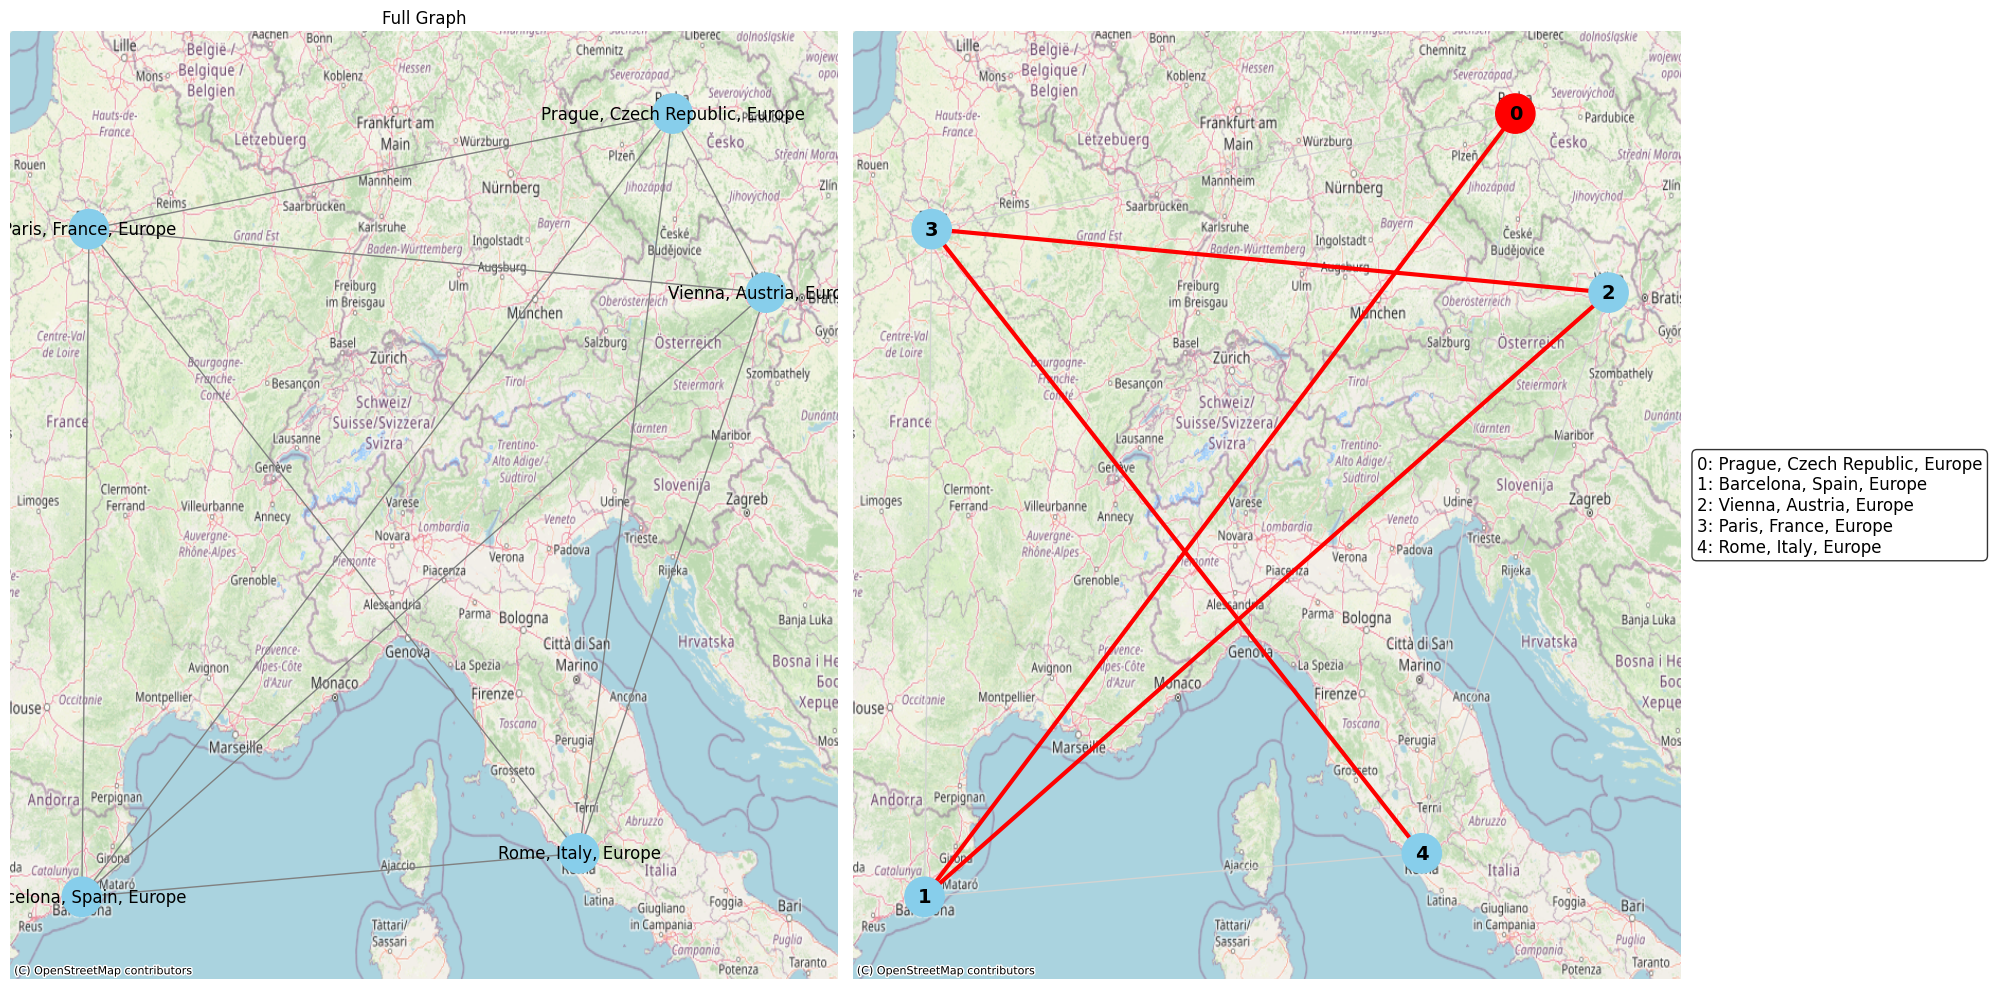

In [81]:
## Price Alone
p = [0, 0, 1] # scale factors for time, distance, price
get_best_method(d, p, len(nodes))
G, labels = build_graph(d, len(nodes), nodes)
tsp_path, total_cost = solve_graph(G, d, original_nodes, cycle = False, name = "price_alone")
plot_graph_and_path(G, tsp_path, positions, nodes, total_cost, 0, map=True, name = "price_alone.png")
plot_route_folium(tsp_path, positions, nodes, total_cost, 0)

Vienna, Austria -> Paris, France: foot, time: 263.19, distance: 1160.40, cost: 0.00
Paris, France -> Prague, Czech Republic: foot, time: 225.99, distance: 993.65, cost: 0.00
Prague, Czech Republic -> Barcelona, Spain: foot, time: 362.07, distance: 1585.92, cost: 0.00
Barcelona, Spain -> Rome, Italy: foot, time: 41.99, distance: 928.53, cost: 0.00
Total time: 893.25 hours.
Total distance: 4668.51 km.
Total cost: 0.00 local currency.
Total weighted cost: 2.95.


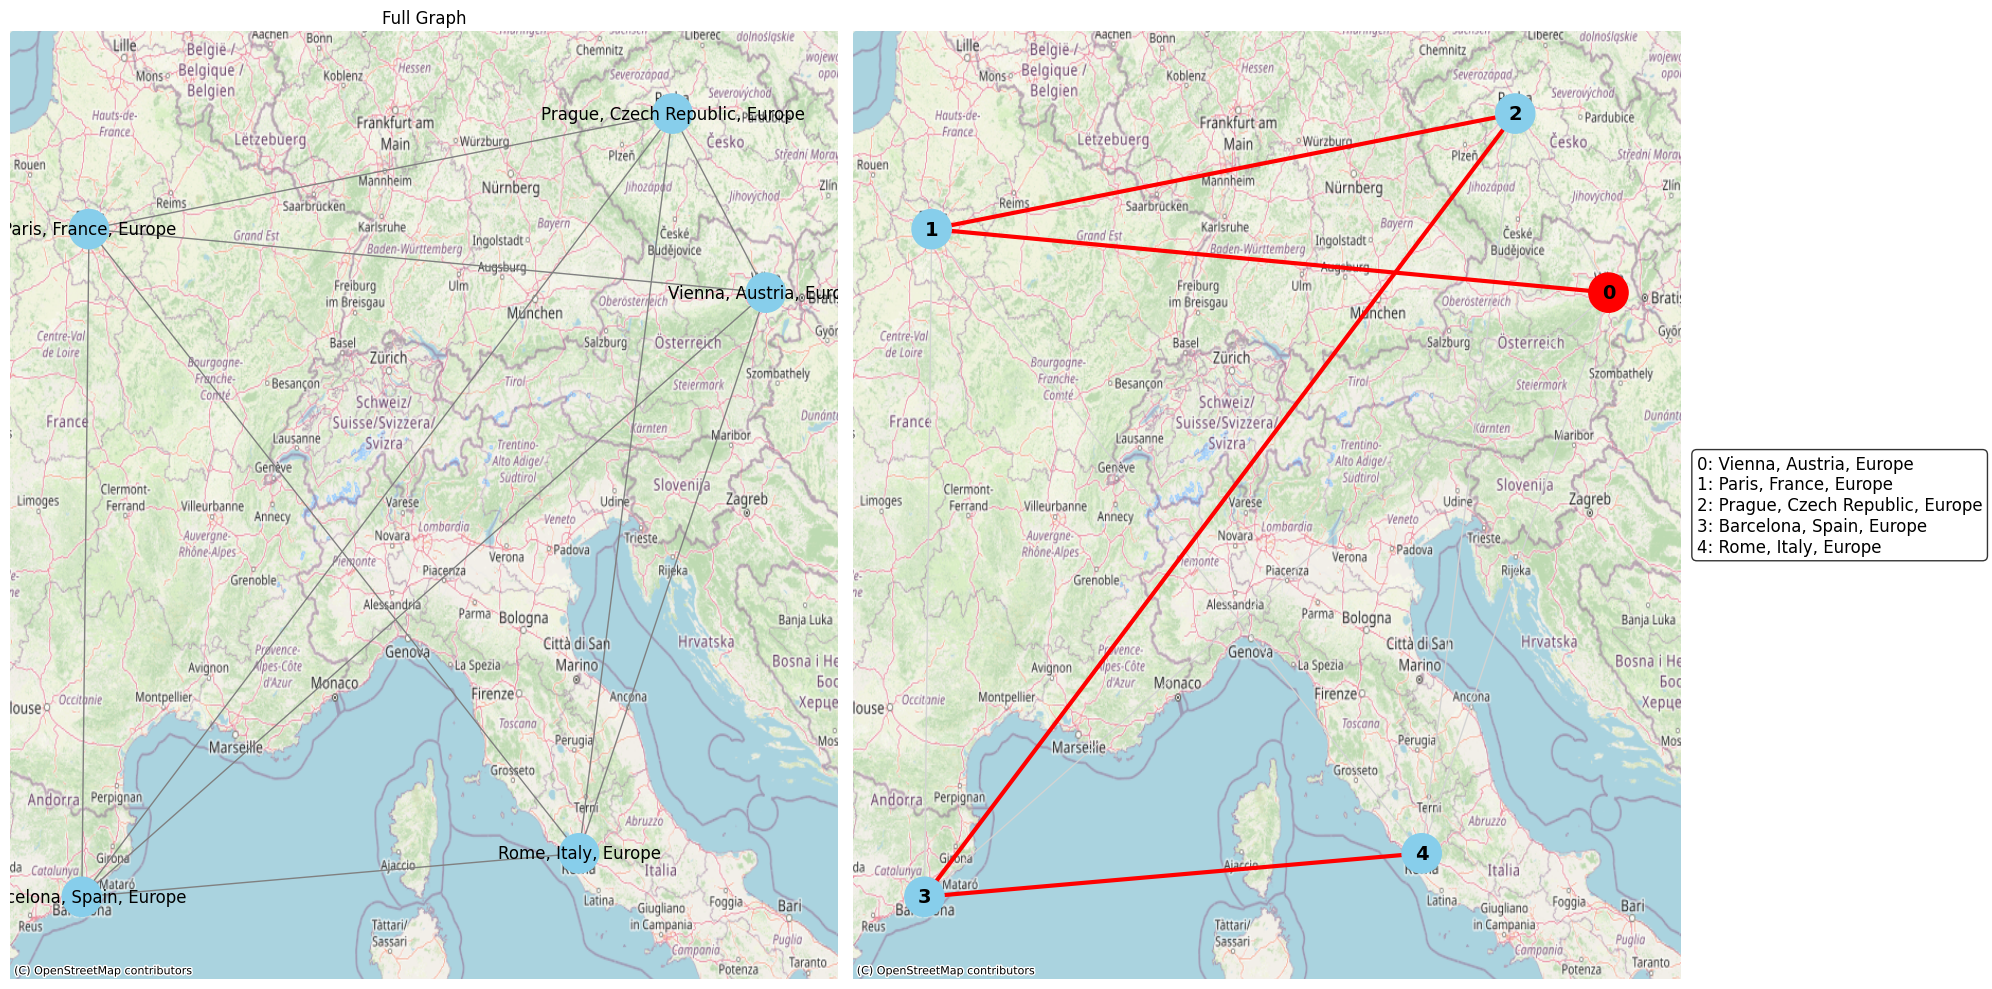

In [84]:
## Distance Alone
p = [0, 1, 0] # scale factors for time, distance, price
get_best_method(d, p, len(nodes))
G, labels = build_graph(d, len(nodes), nodes)
tsp_path, total_cost = solve_graph(G, d, original_nodes, cycle = False, name = "distance_alone")
plot_graph_and_path(G, tsp_path, positions, nodes, total_cost, 0, map=True, name = "distance_alone.png")
plot_route_folium(tsp_path, positions, nodes, total_cost, 0)

Rome, Italy -> Paris, France: transit, time: 13.94, distance: 1374.43, cost: 687.22
Paris, France -> Prague, Czech Republic: car, time: 10.80, distance: 1034.68, cost: 81.38
Prague, Czech Republic -> Barcelona, Spain: car, time: 17.31, distance: 1715.45, cost: 134.92
Barcelona, Spain -> Vienna, Austria: car, time: 17.98, distance: 1778.39, cost: 139.87
Total time: 60.04 hours.
Total distance: 5902.95 km.
Total cost: 1043.38 local currency.
Total weighted cost: 0.19.


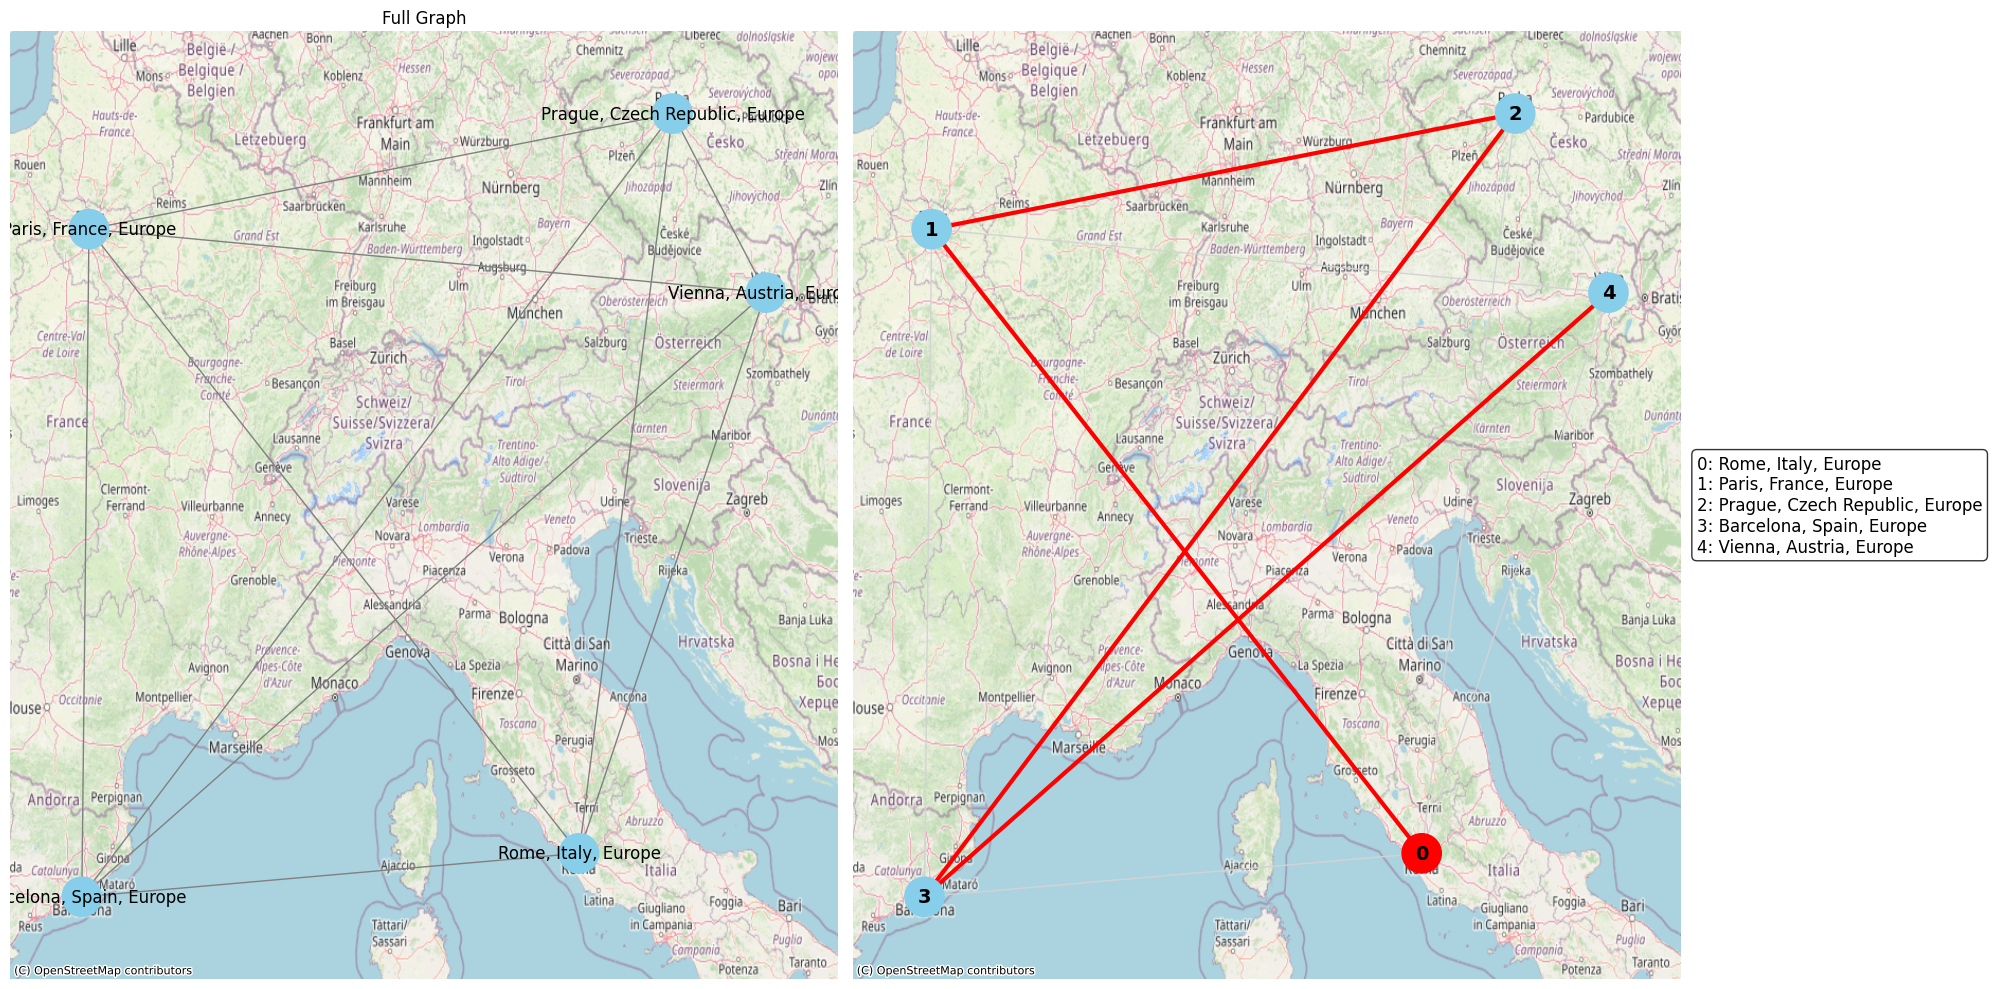

In [85]:
## Time Alone
p = [1, 0, 0] # scale factors for time, distance, price
get_best_method(d, p, len(nodes))
G, labels = build_graph(d, len(nodes), nodes)
tsp_path, total_cost = solve_graph(G, d, original_nodes, cycle = False, name = "time_alone")
plot_graph_and_path(G, tsp_path, positions, nodes, total_cost, 0, map=True, name = "time_alone.png")
plot_route_folium(tsp_path, positions, nodes, total_cost, 0)

Vienna, Austria -> Barcelona, Spain: car, time: 17.98, distance: 1778.39, cost: 139.87
Barcelona, Spain -> Prague, Czech Republic: car, time: 17.31, distance: 1715.45, cost: 134.92
Prague, Czech Republic -> Paris, France: car, time: 10.80, distance: 1034.68, cost: 81.38
Paris, France -> Rome, Italy: car, time: 14.41, distance: 1428.11, cost: 112.32
Total time: 60.51 hours.
Total distance: 5956.62 km.
Total cost: 468.49 local currency.
Total weighted cost: 4.03.


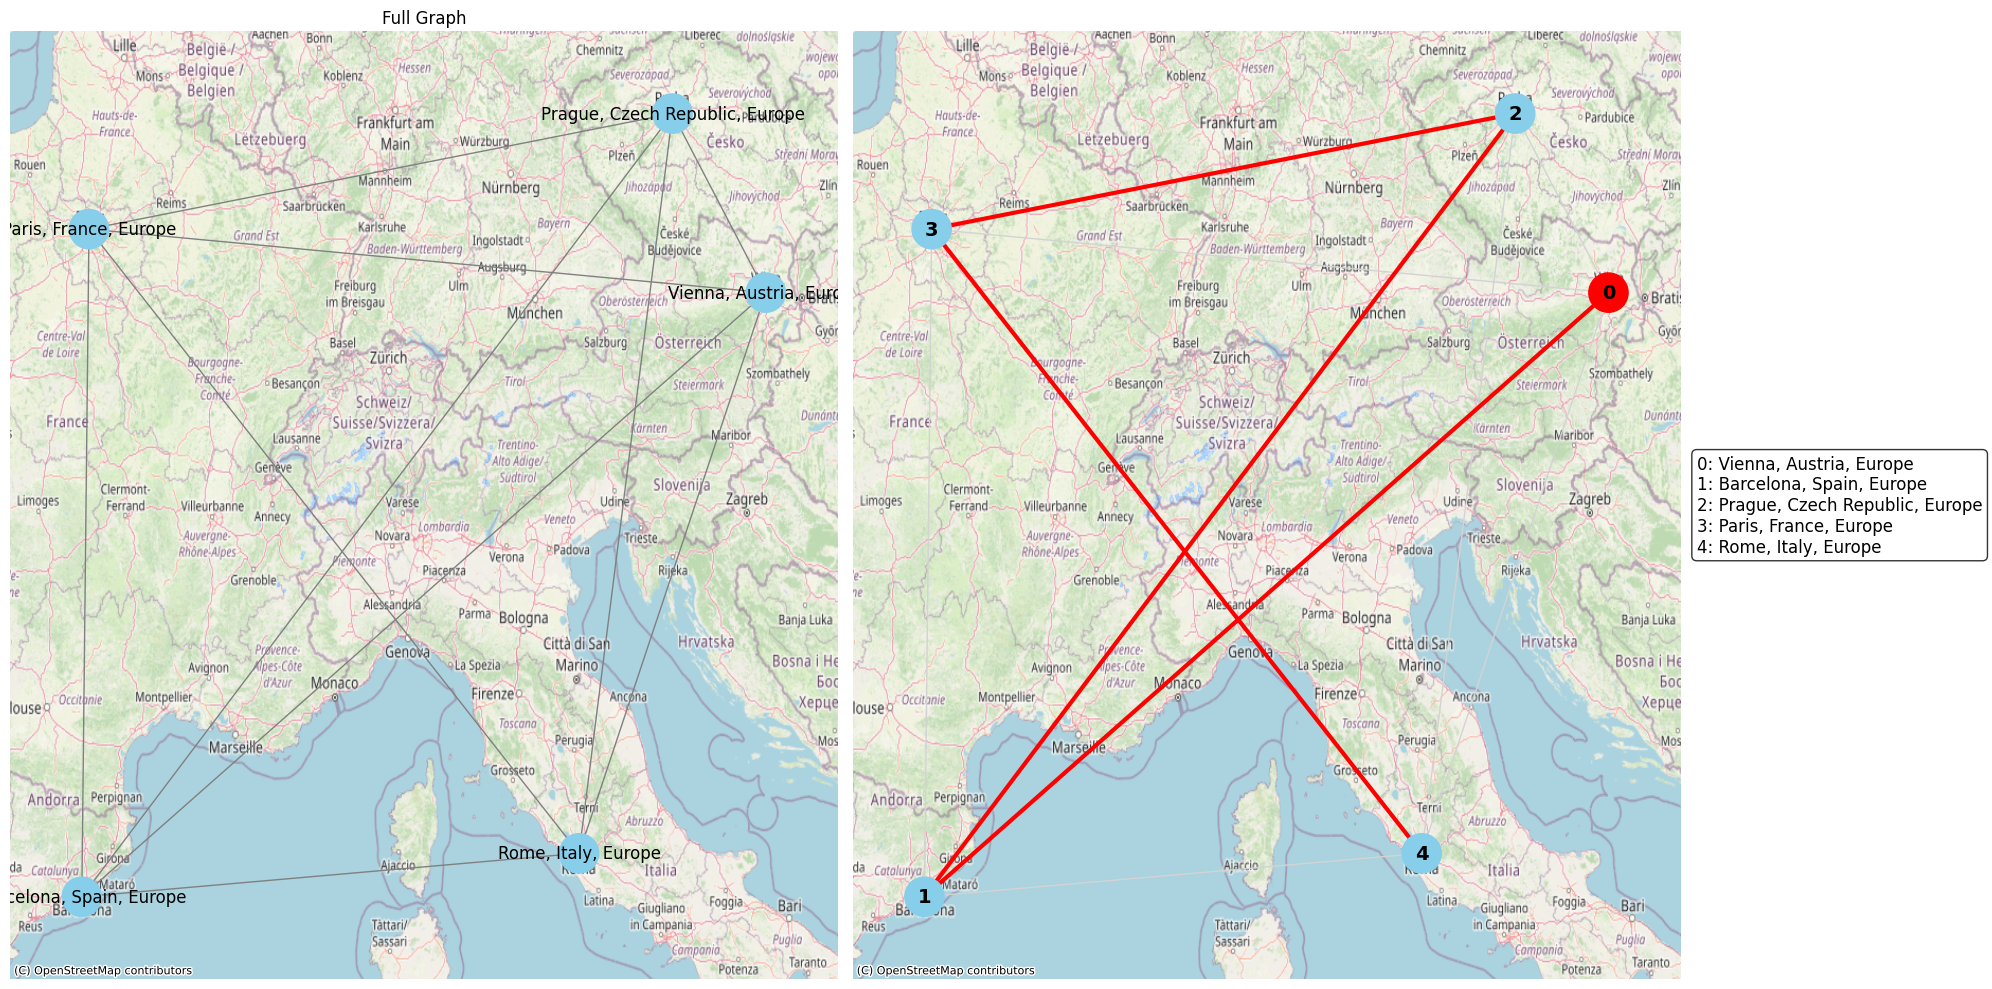

In [86]:
## Combined
p = [1, 1, 1] # scale factors for time, distance, price
get_best_method(d, p, len(nodes))
G, labels = build_graph(d, len(nodes), nodes)
tsp_path, total_cost = solve_graph(G, d, original_nodes, cycle = False, name = "combined")
plot_graph_and_path(G, tsp_path, positions, nodes, 0, 0, map=True, name = "combined.png")
plot_route_folium(tsp_path, positions, nodes, total_cost, 0)